# Week 2 Homework: Geospatial Analysis with Geopandas
**Atlanta Business License Records 2025**

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Load and Prepare the Data

We load the business license Excel file as a regular pandas DataFrame, then convert it to a GeoDataFrame using the latitude and longitude columns already present in the dataset. As covered in the demo, `points_from_xy()` takes **(longitude, latitude)** in that order, and we assign CRS `EPSG:4326` since the coordinates come from a geocoding API that uses the WGS 84 standard.

In [14]:
biz_data = pd.read_excel("/Users/lestermartin/Documents/AI.Data Lab/InvestAtlanta_export/Atlanta_Business_License_Records_2025.xlsx")
print(f"Total records: {len(biz_data)}")
print(f"Records missing coordinates: {biz_data[['latitude', 'longitude']].isna().any(axis=1).sum()}")
biz_data.head(3)

Total records: 17623
Records missing coordinates: 0


,license_number,company_name,company_dba,license_classification,issued_date,naics_code,naics_name,predirection,address_line1,address_line2,...,city,state,postal_code,address_concat,address_api,longitude,latitude,disinvested_neighborhood,council_district,npu
0,GBL-0121-00257,H & H Interiors LLC,NaN,Other Services except Public Administration,2025-01-07 13:21:16.143,541410.0,Interior Design Services,NE,2652 Forrest,NaN,...,Atlanta,GA,NaN,2652 Forrest nan WAY Atlanta GA nan,"2652 Forrest Way NE, Atlanta, Georgia, 30305",-84.379893,33.827640,False,7,B
1,GBL-0121-00258,One Lion Studios LLC,NaN,Other Services except Public Administration,2025-02-16 18:39:21.153,541840.0,Media Representatives,NaN,3343 Peachtree Rd NE,NaN,...,Atlanta,GA,30326,3343 Peachtree Rd NE nan nan Atlanta GA 30326,"3343 Peachtree Rd NE, Atlanta, Georgia, 30326",-84.367109,33.846760,False,7,B
2,GBL-0121-00272,Destingkt Designs LLC,NaN,Other Services except Public Administration,2025-03-04 23:04:53.980,541410.0,Interior Design Services,NaN,931,PONCE DE LEON,...,Atlanta,GA,NaN,931 PONCE DE LEON AVE Atlanta GA nan,"931 Ponce de Leon Ave NE, Atlanta, Georgia, 30306",-84.356939,33.773524,False,2,N


In [15]:
# Convert to GeoDataFrame; points_from_xy takes (x, y) = (longitude, latitude)
biz_geo = gpd.GeoDataFrame(
    biz_data,
    geometry=gpd.points_from_xy(biz_data['longitude'], biz_data['latitude']),
    crs=4326
)
print(f"CRS: {biz_geo.crs}")
biz_geo[['company_name', 'license_classification', 'latitude', 'longitude', 'geometry']].head(3)

CRS: EPSG:4326


,company_name,license_classification,latitude,longitude,geometry
0,H & H Interiors LLC,Other Services except Public Administration,33.827640,-84.379893,POINT (-84.37989 33.82764)
1,One Lion Studios LLC,Other Services except Public Administration,33.846760,-84.367109,POINT (-84.36711 33.84676)
2,Destingkt Designs LLC,Other Services except Public Administration,33.773524,-84.356939,POINT (-84.35694 33.77352)


## Plot 1: All Business License Records (Unfiltered)

We first plot **every record** in the dataset, including any rows with geocoding errors, so we can see the full geographic spread of the data before any cleaning.

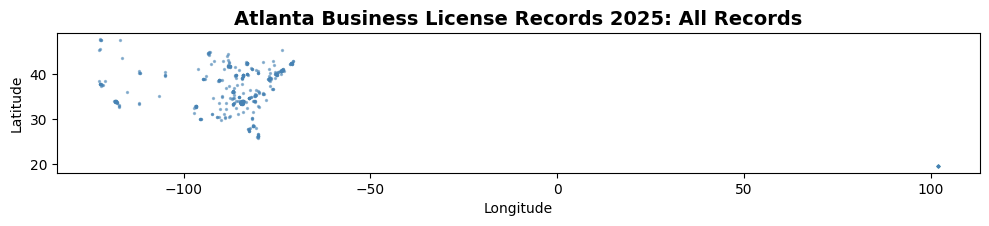

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
biz_geo.plot(ax=ax, markersize=2, color='steelblue', alpha=0.5)
ax.set_title("Atlanta Business License Records 2025: All Records", fontsize=14, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

## Plot 2: Filtered to Atlanta, Colored by Industry Classification

The unfiltered plot reveals points scattered far outside Atlanta — these are **geocoding errors** where addresses could not be resolved accurately. We apply a bounding box filter to restrict the map to the Atlanta metro area, then color each point by its `license_classification` to show the spatial distribution of different industries across the city.

In [17]:
# Filter to Atlanta bounding box to remove geocoding outliers
atl_bounds = (
    (biz_geo['latitude']  >= 33.60) & (biz_geo['latitude']  <= 33.95) &
    (biz_geo['longitude'] >= -84.55) & (biz_geo['longitude'] <= -84.25)
)
biz_atl = biz_geo[atl_bounds].copy()
print(f"Records within Atlanta bounds: {len(biz_atl)} of {len(biz_geo)} total")

Records within Atlanta bounds: 17198 of 17623 total


/var/folders/l7/fpd0j8xj4290fwv7lnxvxmx00000gn/T/ipykernel_55229/361103183.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20', len(categories))


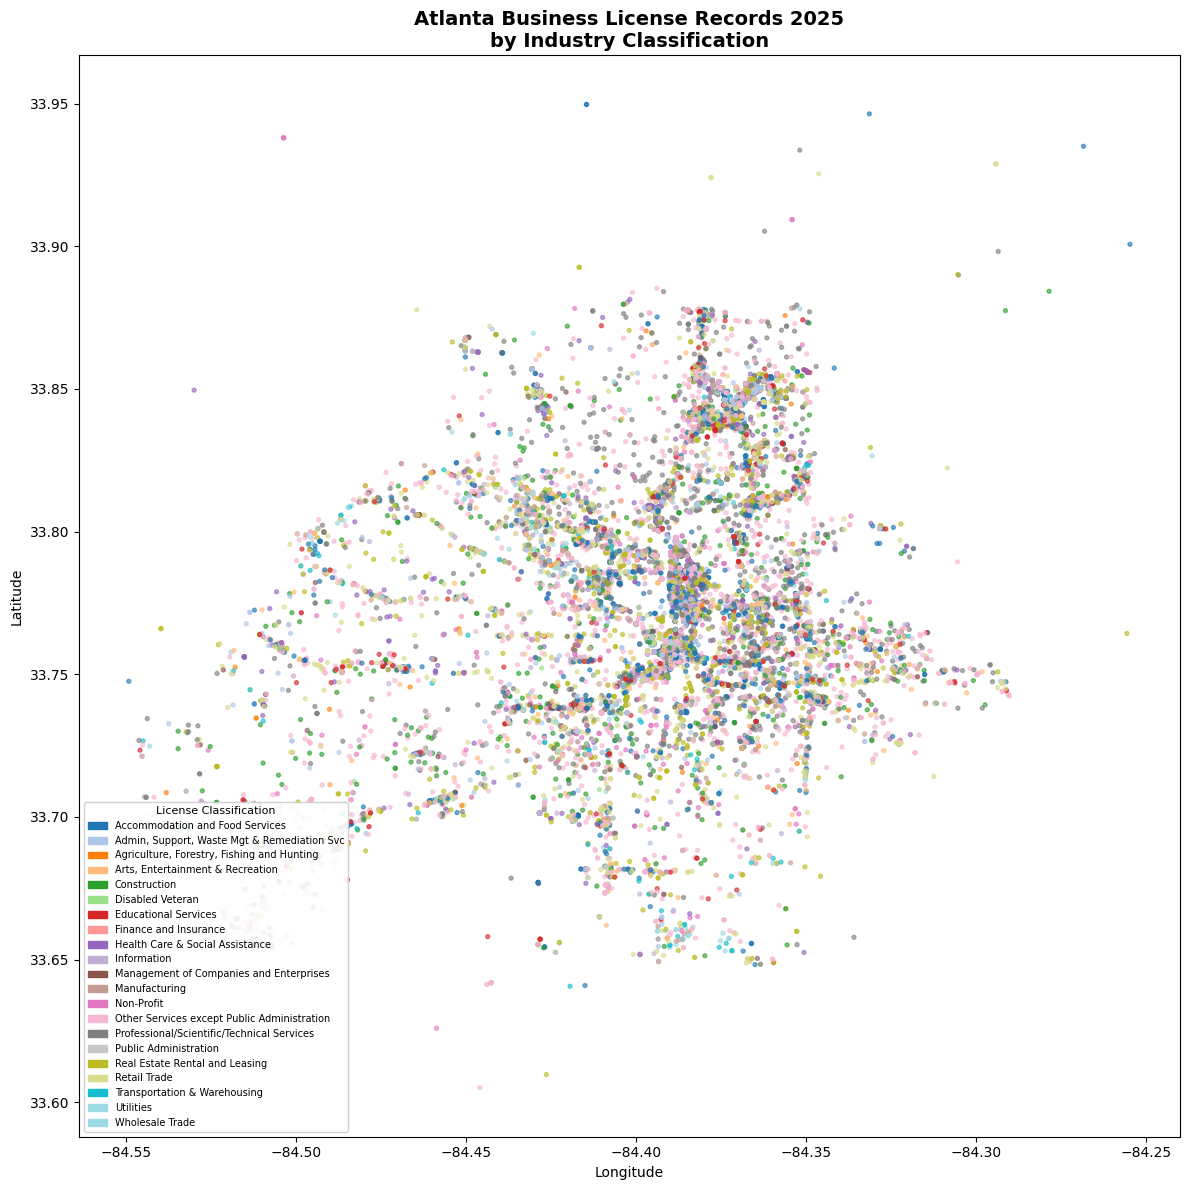

In [18]:
# Assign a color to each unique license classification
categories = biz_atl['license_classification'].fillna('Unknown').unique()
palette = plt.cm.get_cmap('tab20', len(categories))
color_map = {cat: palette(i) for i, cat in enumerate(sorted(categories))}
colors = biz_atl['license_classification'].fillna('Unknown').map(color_map)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    biz_atl.geometry.x,
    biz_atl.geometry.y,
    c=colors,
    s=8,
    alpha=0.6
)

# Legend
legend_handles = [
    mpatches.Patch(color=color_map[cat], label=cat)
    for cat in sorted(color_map)
]
ax.legend(
    handles=legend_handles,
    loc='lower left',
    fontsize=7,
    title='License Classification',
    title_fontsize=8,
    framealpha=0.9
)

ax.set_title("Atlanta Business License Records 2025\nby Industry Classification", fontsize=14, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

## Reflection: What Can You Learn from the Map?

Looking at the business license data spatially reveals several patterns that are completely invisible in a table:

- **Geographic clustering along major corridors**: business activity is noticeably concentrated along north-south arteries (e.g., around Peachtree/Buckhead in the north and along major roads in the southwest), rather than distributed evenly across the city.
- **Industry segregation by neighborhood**: the colored map shows that certain classifications (like Retail Trade or Accommodation and Food Services) tend to cluster in specific zones, suggesting commercial district boundaries that match known areas of Atlanta.
- **Lower business density in some areas**: large portions of the map have very few points, which corresponds to more residential or underserved neighborhoods. This spatial gap is not something you could notice scanning rows in a spreadsheet.
- **Geocoding quality**: the unfiltered Plot 1 immediately shows records placed far outside the city, flagging a data quality issue in the raw dataset that wouldn't be visible without mapping it.

## Reflection: What Surprises You About the Dataset?

Two things stand out as surprising:

1. **The extent of the geocoding errors.** Plot 1 shows points scattered well outside Atlanta's city limits; some appear to be placed in completely wrong locations. This is a reminder that even "clean" datasets from official city sources can have significant coordinate errors when addresses are geocoded programmatically. It also means that any analysis counting businesses per area (e.g., per neighborhood or census tract) would be incorrect if you didn't filter or validate the coordinates first.

2. **The widespread of "Other Services" as a category.** The map and the data show that a large share of licenses fall under the catch-all "Other Services except Public Administration" classification, which makes spatial pattern analysis by industry harder. It suggests that the NAICS-based classification system used here may be too coarse for meaningful neighborhood-level economic analysis without drilling down into the `naics_name` column for finer detail.